In [1]:
import pandas as pd
import sklearn 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [28]:
df_votants = pd.read_csv('database_deputes.csv', index_col=0)
df_votes = pd.read_csv('database_votes2.csv', index_col=0)
df_votes['vote'] = df_votes['vote'].replace({'Non-votant' : 'Nonvotant'})

dep_fictif_2017 = pd.read_csv('dep_fictifs_2017.csv', index_col=0)
dep_fictif_2018 = pd.read_csv('dep_fictifs_2018.csv', index_col=0)
dep_fictif_2019 = pd.read_csv('dep_fictifs_2019.csv', index_col=0)
dep_fictif_2020 = pd.read_csv('dep_fictifs_2020.csv', index_col=0)
dep_fictif_2017 = dep_fictif_2017.replace({'Non-votant' : 'Nonvotant'})
dep_fictif_2018 = dep_fictif_2018.replace({'Non-votant' : 'Nonvotant'})
dep_fictif_2019 = dep_fictif_2019.replace({'Non-votant' : 'Nonvotant'})
dep_fictif_2020 = dep_fictif_2020.replace({'Non-votant' : 'Nonvotant'})
dep_fictif_2017.rename(index={'Mouvement Démocrate (MoDem) et Démocrates apparentés' : 'MoDem et Démocrates apparentés'}, inplace=True)
dep_fictif_2018.rename(index={'Mouvement Démocrate (MoDem) et Démocrates apparentés' : 'MoDem et Démocrates apparentés'}, inplace=True)
dep_fictif_2019.rename(index={'Mouvement Démocrate (MoDem) et Démocrates apparentés' : 'MoDem et Démocrates apparentés'}, inplace=True)
dep_fictif_2020.rename(index={'Mouvement Démocrate (MoDem) et Démocrates apparentés' : 'MoDem et Démocrates apparentés'}, inplace=True)

In [29]:
#On récupère le groupe politique pour chaque député
groupe = df_votes[['idVotant', 'Groupe politique (complet)']].drop_duplicates()
groupe = groupe.set_index('idVotant')
groupe = groupe.rename(columns={'Groupe politique (complet)' : 'Groupe'})
groupe = groupe.replace('Mouvement Démocrate (MoDem) et Démocrates apparentés', 'MoDem et Démocrates apparentés')

# 1. Evolution des votes selon l'année

In [30]:
#On détermine d'abord le cluster de chaque député selon l'historique sur toute la période.
historique_vote = df_votes.copy()
historique_vote = historique_vote.pivot(index = 'idVotant', columns = 'idScrutin', values = 'vote')
#on remplace les NaN par de l'abstention (en confondant abstention et non-votant)
historique_vote = historique_vote.fillna('Non-votant')
historique_vote = pd.get_dummies(historique_vote, drop_first=True)

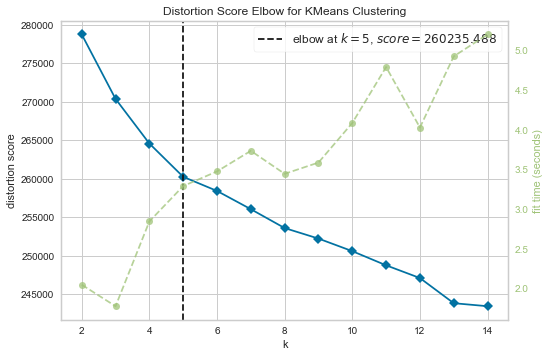

In [5]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,15), metric='distortion') 
visualizer.fit(historique_vote)       
visualizer.show() 

In [31]:
#La règle du coude a déterminé qu'il faut choisir 5 clusters : 
cluster_votes = historique_vote.copy() #refaire une copie à chaque fois !!!

N_CLUSTERS = 5
clustering = KMeans(n_clusters=N_CLUSTERS)
clustering.fit(cluster_votes)

#on détermine ensuite dans quel cluster chaque individu de df_cluster sera affecté :
pred = clustering.predict(cluster_votes)
cluster_votes['cluster'] = pred #on ajoute une colonne au df, qui indique le numéro du cluster auquel appartient chaque individu
cluster = cluster_votes[['cluster']]

In [32]:
#pour associer une couleur à un parti
color_dict = {'Socialistes et apparentés' : 'r',
              'Les Républicains' : 'b',
              'Non inscrit' : 'silver',
              'MoDem et Démocrates apparentés' : 'gold',
              'Libertés et Territoires' : 'dodgerblue', 
              'La France insoumise' : 'darkred',
              'La République en Marche' : 'darkorange', 
              'UDI et Indépendants' : 'cornflowerblue',
              'Gauche démocrate et républicaine' : 'tomato', 
              'Agir ensemble' : 'paleturquoise', 
              'Député fictif' : 'black'}

## Votes de 2017

Variance: [0.0688634  0.06061836 0.03678333 0.02469696 0.02180191 0.0182436
 0.01634548 0.01510885 0.01445748 0.01241049]
Variance totale: 0.289329869102571


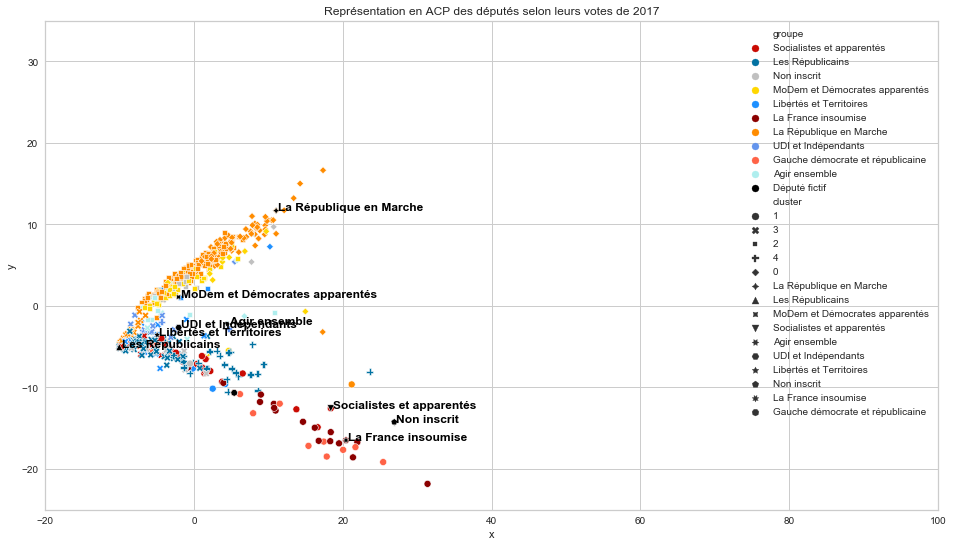

In [40]:
votes_2017 = df_votes[df_votes.date_scrutin < "2018-01-01"].copy()
votes_2017 = votes_2017.pivot(index = 'idVotant', columns = 'idScrutin', values = 'vote')
#on remplace les NaN par de l'abstention (en confondant abstention et non-votant)
votes_2017 = votes_2017.fillna('Nonvotant')
votes_2017.index.name = None
votes_2017.columns.name = None
dep_fictif_2017.columns = votes_2017.columns
votes_2017 = votes_2017.append(dep_fictif_2017)
votes_2017 = pd.get_dummies(votes_2017, drop_first=True)

cluster_fictif_2017 = pd.DataFrame(data=list(dep_fictif_2017.index), index=dep_fictif_2017.index, columns=cluster.columns)
groupe_2017 = cluster.append(cluster_fictif_2017)
cluster_2017 = votes_2017.copy() #refaire une copie à chaque fois !!!
cluster_2017[['cluster']] = groupe_2017
groupe_fictif_2017 = pd.DataFrame(data=['Député fictif']*10, index=dep_fictif_2017.index, columns=groupe.columns)
groupe_etendu = groupe.append(groupe_fictif_2017)
cluster_2017[['groupe']] = groupe_etendu
        
###ACP

groupe_to_labels = {groupe : idx for idx, groupe in enumerate(cluster_2017.groupe.unique())}
labels_to_groupe = {label : groupe for groupe, label in groupe_to_labels.items()}
labels = [groupe_to_labels[groupe] for groupe in cluster_2017.groupe]
cluster_2017['labels'] = labels
cluster_2017_acp = cluster_2017.drop(['cluster', 'labels','groupe'], axis=1)

votes_2017_transform = StandardScaler().fit_transform(cluster_2017_acp)
pca = PCA(n_components=10).fit(votes_2017_transform)

print('Variance:',pca.explained_variance_ratio_)
print('Variance totale:',pca.explained_variance_ratio_.sum())

resultats_reduced = pca.transform(votes_2017_transform)
x_2017 = resultats_reduced[:, 0]
y_2017 = resultats_reduced[:, 1]
y_2017 = -(y_2017)

df_plot_2017 = pd.DataFrame(dict(x=x_2017, y=y_2017, label=labels))
df_plot_2017['groupe'] = df_plot_2017['label'].replace(labels_to_groupe)
df_plot_2017 = pd.merge(df_plot_2017, cluster_2017[['cluster']].reset_index(drop=True), left_index=True, right_index=True)


plt.figure(figsize=(16,9))
plt.ylim([-25, 35])
plt.xlim([-20, 100])
plt.title('Représentation en ACP des députés selon leurs votes de 2017')
g = sns.scatterplot(data=df_plot_2017, x='x', y='y', style='cluster', hue='groupe', palette=color_dict)

for line in range(574,583):
     plt.text(df_plot_2017.x[line]+0.3, df_plot_2017.y[line], df_plot_2017.cluster[line], 
              horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.legend(loc='upper right')
plt.savefig('votes_2017.png')
plt.savefig('2votes_2017.png')
plt.savefig('3votes_2017.png')
plt.savefig('4votes_2017.png')
plt.savefig('5votes_2017.png')

## Votes de 2018

Variance: [0.0623196  0.04560852 0.03094915 0.0270253  0.02109838 0.02022048
 0.01745911 0.01616522 0.01308736 0.0126619 ]
Variance totale: 0.2665950169714633


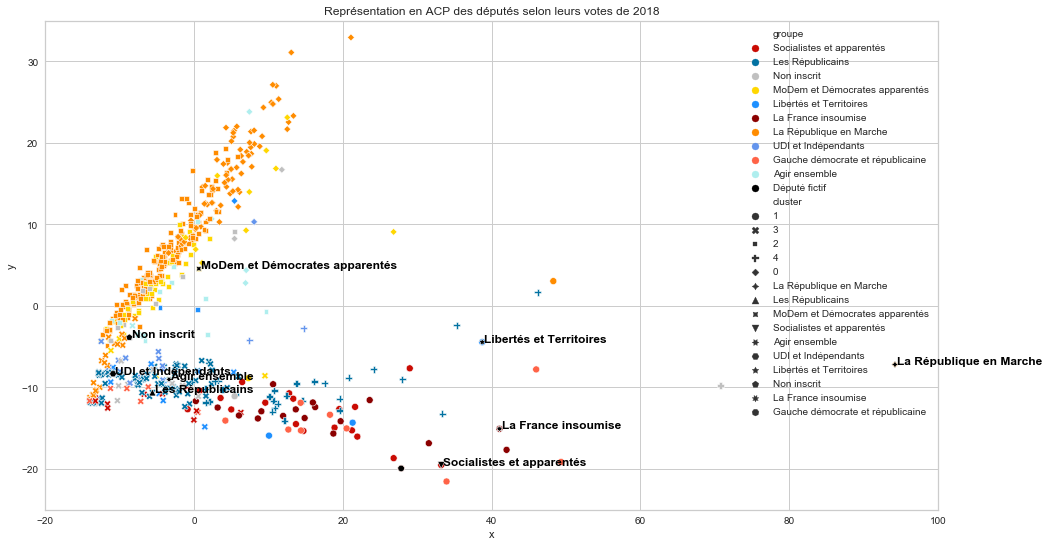

In [39]:
votes_2018 = df_votes[(df_votes.date_scrutin >= "2018-01-01") & (df_votes.date_scrutin < "2019-01-01")].copy()
votes_2018 = votes_2018.pivot(index = 'idVotant', columns = 'idScrutin', values = 'vote')
#on remplace les NaN par de l'abstention (en confondant abstention et non-votant)
votes_2018 = votes_2018.fillna('Nonvotant')
votes_2018.index.name = None
votes_2018.columns.name = None
dep_fictif_2018.columns = votes_2018.columns
votes_2018 = votes_2018.append(dep_fictif_2018)
votes_2018 = pd.get_dummies(votes_2018, drop_first=True)

cluster_fictif_2018 = pd.DataFrame(data=list(dep_fictif_2018.index), index=dep_fictif_2018.index, columns=cluster.columns)
groupe_2018 = cluster.append(cluster_fictif_2018)
cluster_2018 = votes_2018.copy() #refaire une copie à chaque fois !!!
cluster_2018[['cluster']] = groupe_2018
groupe_fictif_2018 = pd.DataFrame(data=['Député fictif']*10, index=dep_fictif_2018.index, columns=groupe.columns)
groupe_etendu = groupe.append(groupe_fictif_2018)
cluster_2018[['groupe']] = groupe_etendu


###ACP

groupe_to_labels = {groupe : idx for idx, groupe in enumerate(cluster_2018.groupe.unique())}
labels_to_groupe = {label : groupe for groupe, label in groupe_to_labels.items()}
labels = [groupe_to_labels[groupe] for groupe in cluster_2018.groupe]
cluster_2018['labels'] = labels
cluster_2018_acp = cluster_2018.drop(['cluster', 'labels','groupe'], axis=1)

votes_2018_transform = StandardScaler().fit_transform(cluster_2018_acp)
pca = PCA(n_components=10).fit(votes_2018_transform)

print('Variance:',pca.explained_variance_ratio_)
print('Variance totale:',pca.explained_variance_ratio_.sum())

resultats_reduced = pca.transform(votes_2018_transform)
x_2018 = resultats_reduced[:, 0]
y_2018 = resultats_reduced[:, 1]

df_plot_2018 = pd.DataFrame(dict(x=x_2018, y=y_2018, label=labels))
df_plot_2018['groupe'] = df_plot_2018['label'].replace(labels_to_groupe)
df_plot_2018 = pd.merge(df_plot_2018, cluster_2018[['cluster']].reset_index(drop=True), left_index=True, right_index=True)
    
plt.figure(figsize=(16,9))  
plt.ylim([-25, 35])
plt.xlim([-20, 100])
plt.title('Représentation en ACP des députés selon leurs votes de 2018')
g = sns.scatterplot(data=df_plot_2018, x='x', y='y', style='cluster', hue='groupe', palette=color_dict)

for line in range(575,584):
     plt.text(df_plot_2018.x[line]+0.3, df_plot_2018.y[line], df_plot_2018.cluster[line], 
              horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.legend(loc='upper right')
plt.savefig('votes_2018.png')
plt.savefig('2votes_2018.png')
plt.savefig('3votes_2018.png')
plt.savefig('4votes_2018.png')
plt.savefig('5votes_2018.png')

## Votes de 2019

Variance: [0.06430637 0.04162069 0.02524234 0.02362372 0.01940297 0.01891312
 0.01510057 0.01455748 0.01281778 0.0114916 ]
Variance totale: 0.2470766404472858


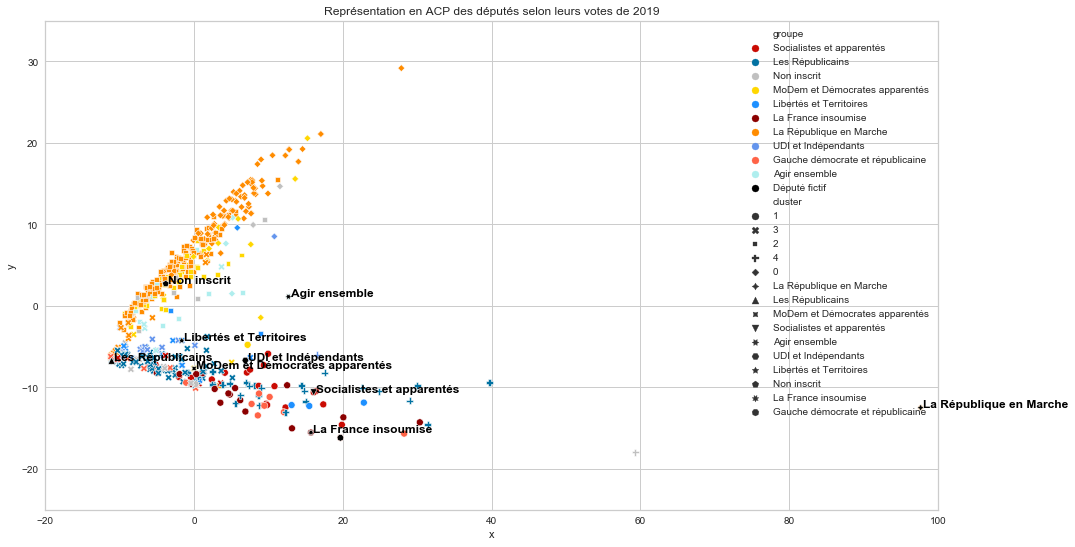

In [38]:
votes_2019 = df_votes[(df_votes.date_scrutin >= "2019-01-01") & (df_votes.date_scrutin < "2020-01-01")].copy()
votes_2019 = votes_2019.pivot(index = 'idVotant', columns = 'idScrutin', values = 'vote')
#on remplace les NaN par de l'abstention (en confondant abstention et non-votant)
votes_2019 = votes_2019.fillna('Nonvotant')
votes_2019.index.name = None
votes_2019.columns.name = None
dep_fictif_2019.columns = votes_2019.columns
votes_2019 = votes_2019.append(dep_fictif_2019)
votes_2019 = pd.get_dummies(votes_2019, drop_first=True)

cluster_fictif_2019 = pd.DataFrame(data=list(dep_fictif_2019.index), index=dep_fictif_2019.index, columns=cluster.columns)
groupe_2019 = cluster.append(cluster_fictif_2019)
cluster_2019 = votes_2019.copy() #refaire une copie à chaque fois !!!
cluster_2019[['cluster']] = groupe_2019
groupe_fictif_2019 = pd.DataFrame(data=['Député fictif']*10, index=dep_fictif_2019.index, columns=groupe.columns)
groupe_etendu = groupe.append(groupe_fictif_2019)
cluster_2019[['groupe']] = groupe_etendu


###ACP

groupe_to_labels = {groupe : idx for idx, groupe in enumerate(cluster_2019.groupe.unique())}
labels_to_groupe = {label : groupe for groupe, label in groupe_to_labels.items()}
labels = [groupe_to_labels[groupe] for groupe in cluster_2019.groupe]
cluster_2019['labels'] = labels
cluster_2019_acp = cluster_2019.drop(['cluster', 'labels','groupe'], axis=1)

votes_2019_transform = StandardScaler().fit_transform(cluster_2019_acp)
pca = PCA(n_components=10).fit(votes_2019_transform)

print('Variance:',pca.explained_variance_ratio_)
print('Variance totale:',pca.explained_variance_ratio_.sum())

resultats_reduced = pca.transform(votes_2019_transform)
x_2019 = resultats_reduced[:, 0]
y_2019 = resultats_reduced[:, 1]

df_plot_2019 = pd.DataFrame(dict(x=x_2019, y=y_2019, label=labels))
df_plot_2019['groupe'] = df_plot_2019['label'].replace(labels_to_groupe)
df_plot_2019 = pd.merge(df_plot_2019, cluster_2019[['cluster']].reset_index(drop=True), left_index=True, right_index=True)
    
plt.figure(figsize=(16,9))    
plt.ylim([-25, 35])
plt.xlim([-20, 100])
plt.title('Représentation en ACP des députés selon leurs votes de 2019')
g = sns.scatterplot(data=df_plot_2019, x='x', y='y', style='cluster', hue='groupe', palette=color_dict)

for line in range(574,583):
     plt.text(df_plot_2019.x[line]+0.3, df_plot_2019.y[line], df_plot_2019.cluster[line], 
              horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.legend(loc='upper right')
plt.savefig('votes_2019.png')
plt.savefig('2votes_2019.png')
plt.savefig('3votes_2019.png')
plt.savefig('4votes_2019.png')
plt.savefig('5votes_2019.png')

## Votes de 2020

Variance: [0.07005614 0.05309314 0.03258776 0.0203372  0.01649265 0.01633463
 0.0149066  0.01419898 0.01334155 0.01230957]
Variance totale: 0.2636582255961046


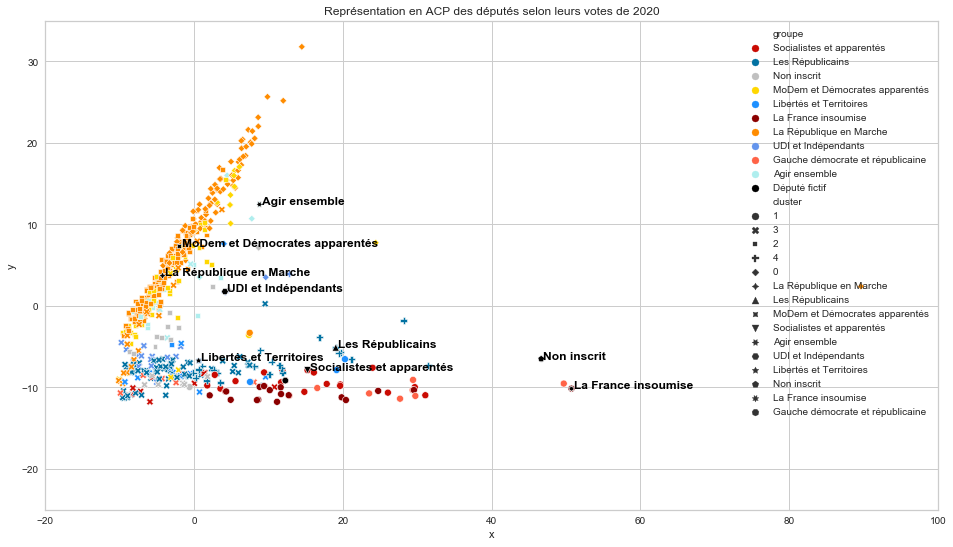

In [37]:
votes_2020 = df_votes[df_votes.date_scrutin >= "2020-01-01"].copy()
votes_2020 = votes_2020.pivot(index = 'idVotant', columns = 'idScrutin', values = 'vote')
#on remplace les NaN par de l'abstention (en confondant abstention et non-votant)
votes_2020 = votes_2020.fillna('Nonvotant')
votes_2020.index.name = None
votes_2020.columns.name = None
dep_fictif_2020.columns = votes_2020.columns
votes_2020 = votes_2020.append(dep_fictif_2020)
votes_2020 = pd.get_dummies(votes_2020, drop_first=True)

cluster_fictif_2020 = pd.DataFrame(data=list(dep_fictif_2020.index), index=dep_fictif_2020.index, columns=cluster.columns)
groupe_2020 = cluster.append(cluster_fictif_2020)
cluster_2020 = votes_2020.copy() #refaire une copie à chaque fois !!!
cluster_2020[['cluster']] = groupe_2020
groupe_fictif_2020 = pd.DataFrame(data=['Député fictif']*10, index=dep_fictif_2020.index, columns=groupe.columns)
groupe_etendu = groupe.append(groupe_fictif_2020)
cluster_2020[['groupe']] = groupe_etendu
###ACP

groupe_to_labels = {groupe : idx for idx, groupe in enumerate(cluster_2020.groupe.unique())}
labels_to_groupe = {label : groupe for groupe, label in groupe_to_labels.items()}
labels = [groupe_to_labels[groupe] for groupe in cluster_2020.groupe]
cluster_2020['labels'] = labels
cluster_2020_acp = cluster_2020.drop(['cluster', 'labels','groupe'], axis=1)

votes_2020_transform = StandardScaler().fit_transform(cluster_2020_acp)
pca = PCA(n_components=10).fit(votes_2020_transform)

print('Variance:',pca.explained_variance_ratio_)
print('Variance totale:',pca.explained_variance_ratio_.sum())

resultats_reduced = pca.transform(votes_2020_transform)
x_2020 = resultats_reduced[:, 0]
y_2020 = resultats_reduced[:, 1]

df_plot_2020 = pd.DataFrame(dict(x=x_2020, y=y_2020, label=labels))
df_plot_2020['groupe'] = df_plot_2020['label'].replace(labels_to_groupe)
df_plot_2020 = pd.merge(df_plot_2020, cluster_2020[['cluster']].reset_index(drop=True), left_index=True, right_index=True)
    
plt.figure(figsize=(16,9))    
plt.ylim([-25, 35])
plt.xlim([-20, 100])
plt.title('Représentation en ACP des députés selon leurs votes de 2020')
g = sns.scatterplot(data=df_plot_2020, x='x', y='y', style='cluster', hue='groupe', palette=color_dict)

for line in range(575,584):
     plt.text(df_plot_2020.x[line]+0.3, df_plot_2020.y[line], df_plot_2020.cluster[line], 
              horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.legend(loc='upper right')
plt.savefig('votes_2020.png')
plt.savefig('2votes_2020.png')
plt.savefig('3votes_2020.png')
plt.savefig('4votes_2020.png')
plt.savefig('5votes_2020.png')

In [41]:
import imageio 
images = [] 
filenames=['votes_2017.png', '2votes_2017.png', '3votes_2017.png', '4votes_2017.png', '5votes_2017.png',
           'votes_2018.png', '2votes_2018.png', '3votes_2018.png', '4votes_2018.png', '5votes_2018.png',
           'votes_2019.png', '2votes_2019.png', '3votes_2019.png', '4votes_2019.png', '5votes_2019.png',
           'votes_2020.png', '2votes_2020.png', '3votes_2020.png', '4votes_2020.png', '5votes_2020.png'] 
for filename in filenames: 
    images.append(imageio.imread(filename)) 
    imageio.mimsave('votes.gif', images)
plt.clf()
from IPython.display import Image
display(Image(url='votes.gif'))

<Figure size 576x396 with 0 Axes>

# 2. Evolution des indices

In [13]:
#Indices

proportion_vote = pd.read_csv('proportion_vote.csv', index_col=0)

indice_accord = pd.read_csv('indice_accord.csv', index_col=0)
indice_accord = indice_accord[['idVotant', 'IndiceAccord']]
indice_accord = indice_accord.rename(columns={'IndiceAccord' : 'indice_accord'})

participation = df_votes.groupby('idVotant').count()
participation['taux_participation'] = participation['idScrutin']/3117*100
participation = participation[['taux_participation']]

df_indices = proportion_vote.merge(indice_accord, on='idVotant', how='left')
df_indices = df_indices.merge(participation, on='idVotant', how='left')
df_indices = df_indices.set_index('idVotant')

In [14]:
cluster_indices = df_indices.copy() #refaire une copie à chaque fois !!!

N_CLUSTERS = 2
clustering = KMeans(n_clusters=N_CLUSTERS)
clustering.fit(cluster_indices)

#on détermine ensuite dans quel cluster chaque individu de df_cluster sera affecté :
pred = clustering.predict(cluster_indices)
df_indices['cluster'] = pred #on ajoute une colonne au df, qui indique le numéro du cluster auquel appartient chaque individu

### 2017

In [15]:
votes_2017 = df_votes[df_votes.date_scrutin < "2018-01-01"].copy()

#taux de participation
nb_votes_2017 = votes_2017['idScrutin'].nunique()
participation_2017 = votes_2017.groupby('idVotant').count()
participation_2017['taux_participation'] = participation_2017['idScrutin']/(nb_votes_2017)*100
participation_2017 = participation_2017[['taux_participation']]
participation_2017 = participation_2017.merge(groupe, on='idVotant', how='left')
participation_groupe_2017 = participation_2017.groupby('Groupe').mean()
participation_2017 = participation_2017.drop('Groupe', axis=1)
participation_2017 = participation_2017.append(participation_groupe_2017)
participation_2017.index.name = 'idVotant'

#proportion vote
avis_votant_2017 = pd.DataFrame(votes_2017.groupby(['idVotant']).vote.value_counts())
avis_votant_2017 = avis_votant_2017.rename(columns={'vote':'nombre'})
total_votant_2017 = votes_2017.groupby(['idVotant']).vote.count()
proportion_2017 = pd.DataFrame({'Proportion' : np.round(avis_votant_2017['nombre'].div(total_votant_2017)*100, decimals=2)})
proportion_2017 = proportion_2017.unstack()
proportion_2017.columns = proportion_2017.columns.droplevel()
proportion_2017 = proportion_2017.drop('Nonvotant', axis=1)
proportion_2017 = proportion_2017.fillna(0)
proportion_2017 = proportion_2017.merge(groupe, on='idVotant', how='left')
proportion_groupe_2017 = proportion_2017.groupby('Groupe').mean()
proportion_2017 = proportion_2017.drop('Groupe', axis=1)
proportion_2017 = proportion_2017.append(proportion_groupe_2017)
proportion_2017.index.name = 'idVotant'


#indice accord
partis = pd.DataFrame(votes_2017.groupby('idVotant')['organeRefGroupe'].unique())
df_2017 = votes_2017[((votes_2017.vote == 'Pour') & (votes_2017.resultat == 'adopté')) | ((votes_2017.vote == 'Contre') & (votes_2017.resultat == 'rejeté'))]
accord_votant = df_2017.idVotant.value_counts() 
total_votant = votes_2017.idVotant.value_counts()
indice_accord_2017 = pd.DataFrame((np.round(accord_votant/total_votant*100, decimals=2))).rename(columns={'idVotant':'indice_accord'})
indice_accord_2017.index = indice_accord_2017.index.rename('idVotant')
indice_accord_2017 = indice_accord_2017.merge(groupe, on='idVotant', how='left')
indice_groupe_2017 = indice_accord_2017.groupby('Groupe').mean()
indice_accord_2017 = indice_accord_2017.drop('Groupe', axis=1)
indice_accord_2017 = indice_accord_2017.append(indice_groupe_2017)
indice_accord_2017.index.name = 'idVotant'


#df final
indices_2017 = proportion_2017.merge(indice_accord_2017, on='idVotant', how='left')
indices_2017 = indices_2017.merge(participation_2017, on='idVotant', how='left')
indices_2017 = indices_2017.fillna(0)

Variance: [0.72807105 0.2017302  0.06528147 0.00491728]
Variance totale: 1.0


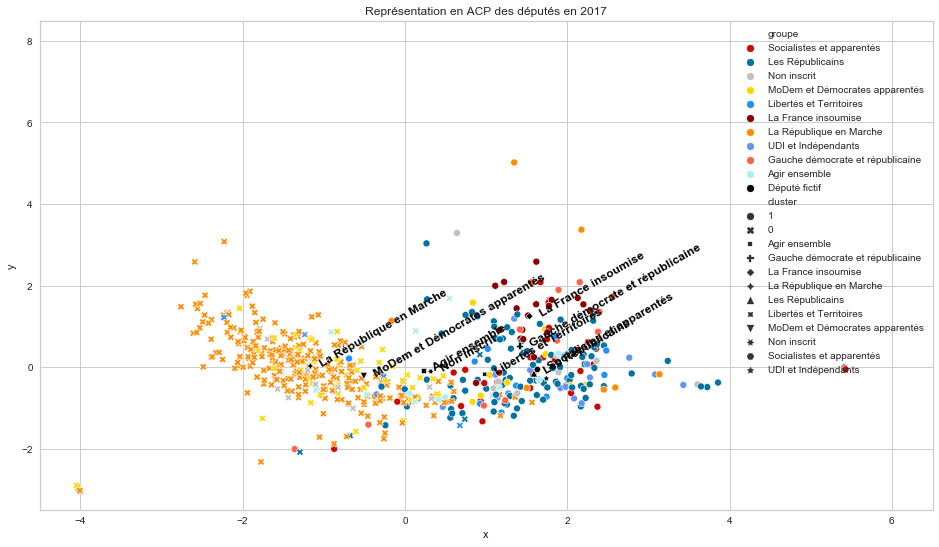

In [16]:
indices_cluster = df_indices[['cluster']]
cluster_fictif = pd.DataFrame(data=dep_fictif_2017.index, index=dep_fictif_2017.index, columns=indices_cluster.columns)
indices_cluster = indices_cluster.append(cluster_fictif)
indices_cluster.index.name = 'idVotant'

indices_2017 = indices_2017.merge(indices_cluster, on='idVotant', how='left')
groupe_fictif_2017 = pd.DataFrame(data=['Député fictif']*10, index=dep_fictif_2017.index, columns=groupe.columns)
groupe_etendu = groupe.append(groupe_fictif_2017)
groupe_etendu.index.name = 'idVotant'
indices_2017 = indices_2017.merge(groupe_etendu, on='idVotant', how='left')

groupe_to_labels = {groupe : idx for idx, groupe in enumerate(indices_2017.Groupe.unique())}
labels_to_groupe = {label : groupe for groupe, label in groupe_to_labels.items()}
labels = [groupe_to_labels[groupe] for groupe in indices_2017.Groupe]
indices_2017['labels'] = labels
indices_2017_acp = indices_2017.drop(['cluster','labels','Groupe'], axis=1)

indices_2017_transform = StandardScaler().fit_transform(indices_2017_acp)
pca = PCA(n_components=4).fit(indices_2017_transform)

print('Variance:',pca.explained_variance_ratio_)
print('Variance totale:',pca.explained_variance_ratio_.sum())

resultats_reduced = pca.transform(indices_2017_transform)
x_2017 = resultats_reduced[:, 0]
y_2017 = resultats_reduced[:, 1]

df_plot_2017 = pd.DataFrame(dict(x=x_2017, y=y_2017, label=labels))
df_plot_2017.index = indices_2017.index
df_plot_2017 = df_plot_2017.merge(indices_2017[['cluster']], on='idVotant', how='left')
df_plot_2017['groupe'] = df_plot_2017['label'].replace(labels_to_groupe)

plt.figure(figsize=(16,9))
plt.ylim([-3.5, 8.5])
plt.xlim([-4.5, 6.5])
plt.title('Représentation en ACP des députés en 2017')
g = sns.scatterplot(data=df_plot_2017, x='x', y='y', style='cluster', hue='groupe', palette=color_dict)

for line in range(574,583):
     plt.text(df_plot_2017.x[line]+0.1, df_plot_2017.y[line], df_plot_2017.cluster[line], 
              horizontalalignment='left', size='medium', color='black', weight='semibold', rotation=30.)

plt.legend(loc='upper right')
plt.savefig('indices_2017.png')
plt.savefig('2indices_2017.png')
plt.savefig('3indices_2017.png')
plt.savefig('4indices_2017.png')

### 2018

In [17]:
votes_2018 = df_votes[(df_votes.date_scrutin >= "2018-01-01") & (df_votes.date_scrutin < "2019-01-01")].copy()

#taux de participation
nb_votes_2018 = votes_2018['idScrutin'].nunique()
participation_2018 = votes_2018.groupby('idVotant').count()
participation_2018['taux_participation'] = participation_2018['idScrutin']/(nb_votes_2018)*100
participation_2018 = participation_2018[['taux_participation']]
participation_2018 = participation_2018.merge(groupe, on='idVotant', how='left')
participation_groupe_2018 = participation_2018.groupby('Groupe').mean()
participation_2018 = participation_2018.drop('Groupe', axis=1)
participation_2018 = participation_2018.append(participation_groupe_2018)
participation_2018.index.name = 'idVotant'

#proportion vote
avis_votant_2018 = pd.DataFrame(votes_2018.groupby(['idVotant']).vote.value_counts())
avis_votant_2018 = avis_votant_2018.rename(columns={'vote':'nombre'})
total_votant_2018 = votes_2018.groupby(['idVotant']).vote.count()
proportion_2018 = pd.DataFrame({'Proportion' : np.round(avis_votant_2018['nombre'].div(total_votant_2018)*100, decimals=2)})
proportion_2018 = proportion_2018.unstack()
proportion_2018.columns = proportion_2018.columns.droplevel()
proportion_2018 = proportion_2018.drop('Nonvotant', axis=1)
proportion_2018 = proportion_2018.fillna(0)
proportion_2018 = proportion_2018.merge(groupe, on='idVotant', how='left')
proportion_groupe_2018 = proportion_2018.groupby('Groupe').mean()
proportion_2018 = proportion_2018.drop('Groupe', axis=1)
proportion_2018 = proportion_2018.append(proportion_groupe_2018)
proportion_2018.index.name = 'idVotant'


#indice accord
partis = pd.DataFrame(votes_2018.groupby('idVotant')['organeRefGroupe'].unique())
df_2018 = votes_2018[((votes_2018.vote == 'Pour') & (votes_2018.resultat == 'adopté')) | ((votes_2018.vote == 'Contre') & (votes_2018.resultat == 'rejeté'))]
accord_votant = df_2018.idVotant.value_counts() 
total_votant = votes_2018.idVotant.value_counts()
indice_accord_2018 = pd.DataFrame((np.round(accord_votant/total_votant*100, decimals=2))).rename(columns={'idVotant':'indice_accord'})
indice_accord_2018.index = indice_accord_2018.index.rename('idVotant')
indice_accord_2018 = indice_accord_2018.merge(groupe, on='idVotant', how='left')
indice_groupe_2018 = indice_accord_2018.groupby('Groupe').mean()
indice_accord_2018 = indice_accord_2018.drop('Groupe', axis=1)
indice_accord_2018 = indice_accord_2018.append(indice_groupe_2018)
indice_accord_2018.index.name = 'idVotant'


#df final
indices_2018 = proportion_2018.merge(indice_accord_2018, on='idVotant', how='left')
indices_2018 = indices_2018.merge(participation_2018, on='idVotant', how='left')
indices_2018 = indices_2018.fillna(0)

Variance: [0.73889006 0.21795468 0.03868466 0.00447061]
Variance totale: 0.9999999999999999


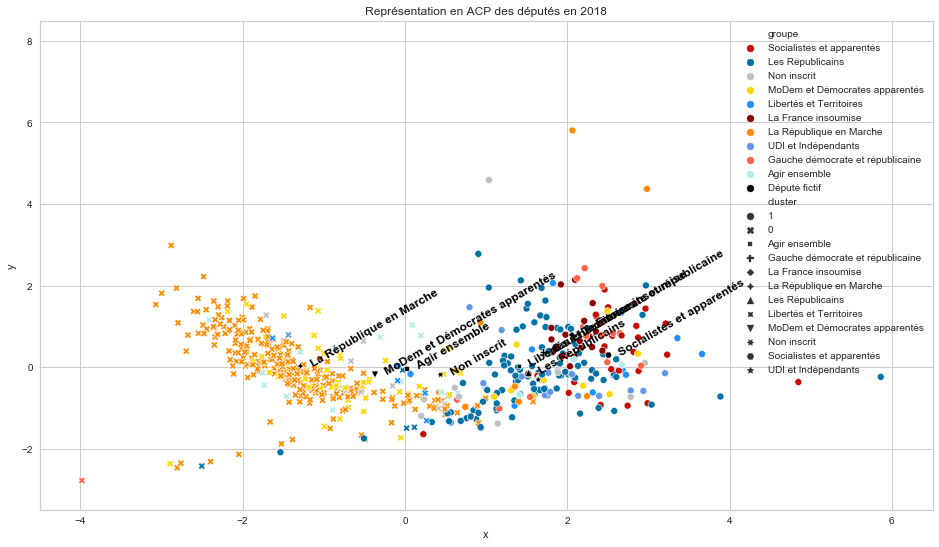

In [18]:
indices_cluster = df_indices[['cluster']]
cluster_fictif = pd.DataFrame(data=dep_fictif_2018.index, index=dep_fictif_2018.index, columns=indices_cluster.columns)
indices_cluster = indices_cluster.append(cluster_fictif)
indices_cluster.index.name = 'idVotant'

indices_2018 = indices_2018.merge(indices_cluster, on='idVotant', how='left')
groupe_fictif_2018 = pd.DataFrame(data=['Député fictif']*10, index=dep_fictif_2018.index, columns=groupe.columns)
groupe_etendu = groupe.append(groupe_fictif_2018)
groupe_etendu.index.name = 'idVotant'
indices_2018 = indices_2018.merge(groupe_etendu, on='idVotant', how='left')

groupe_to_labels = {groupe : idx for idx, groupe in enumerate(indices_2018.Groupe.unique())}
labels_to_groupe = {label : groupe for groupe, label in groupe_to_labels.items()}
labels = [groupe_to_labels[groupe] for groupe in indices_2018.Groupe]
indices_2018['labels'] = labels
indices_2018_acp = indices_2018.drop(['cluster','labels','Groupe'], axis=1)

indices_2018_transform = StandardScaler().fit_transform(indices_2018_acp)
pca = PCA(n_components=4).fit(indices_2018_transform)

print('Variance:',pca.explained_variance_ratio_)
print('Variance totale:',pca.explained_variance_ratio_.sum())

resultats_reduced = pca.transform(indices_2018_transform)
x_2018 = resultats_reduced[:, 0]
y_2018 = resultats_reduced[:, 1]

df_plot_2018 = pd.DataFrame(dict(x=x_2018, y=y_2018, label=labels))
df_plot_2018.index = indices_2018.index
df_plot_2018 = df_plot_2018.merge(indices_2018[['cluster']], on='idVotant', how='left')
df_plot_2018['groupe'] = df_plot_2018['label'].replace(labels_to_groupe)

plt.figure(figsize=(16,9))
plt.ylim([-3.5, 8.5])
plt.xlim([-4.5, 6.5])
plt.title('Représentation en ACP des députés en 2018')
g = sns.scatterplot(data=df_plot_2018, x='x', y='y', style='cluster', hue='groupe', palette=color_dict)

for line in range(575,584):
     plt.text(df_plot_2018.x[line]+0.1, df_plot_2018.y[line], df_plot_2018.cluster[line], 
              horizontalalignment='left', size='medium', color='black', weight='semibold', rotation=30.)

plt.legend(loc='upper right')
plt.savefig('indices_2018.png')
plt.savefig('2indices_2018.png')
plt.savefig('3indices_2018.png')
plt.savefig('4indices_2018.png')

### 2019

In [19]:
votes_2019 = df_votes[(df_votes.date_scrutin >= "2019-01-01") & (df_votes.date_scrutin < "2020-01-01")].copy()

#taux de participation
nb_votes_2019 = votes_2019['idScrutin'].nunique()
participation_2019 = votes_2019.groupby('idVotant').count()
participation_2019['taux_participation'] = participation_2019['idScrutin']/(nb_votes_2019)*100
participation_2019 = participation_2019[['taux_participation']]
participation_2019 = participation_2019.merge(groupe, on='idVotant', how='left')
participation_groupe_2019 = participation_2019.groupby('Groupe').mean()
participation_2019 = participation_2019.drop('Groupe', axis=1)
participation_2019 = participation_2019.append(participation_groupe_2019)
participation_2019.index.name = 'idVotant'

#proportion vote
avis_votant_2019 = pd.DataFrame(votes_2019.groupby(['idVotant']).vote.value_counts())
avis_votant_2019 = avis_votant_2019.rename(columns={'vote':'nombre'})
total_votant_2019 = votes_2019.groupby(['idVotant']).vote.count()
proportion_2019 = pd.DataFrame({'Proportion' : np.round(avis_votant_2019['nombre'].div(total_votant_2019)*100, decimals=2)})
proportion_2019 = proportion_2019.unstack()
proportion_2019.columns = proportion_2019.columns.droplevel()
proportion_2019 = proportion_2019.drop('Nonvotant', axis=1)
proportion_2019 = proportion_2019.fillna(0)
proportion_2019 = proportion_2019.merge(groupe, on='idVotant', how='left')
proportion_groupe_2019 = proportion_2019.groupby('Groupe').mean()
proportion_2019 = proportion_2019.drop('Groupe', axis=1)
proportion_2019 = proportion_2019.append(proportion_groupe_2019)
proportion_2019.index.name = 'idVotant'


#indice accord
partis = pd.DataFrame(votes_2019.groupby('idVotant')['organeRefGroupe'].unique())
df_2019 = votes_2019[((votes_2019.vote == 'Pour') & (votes_2019.resultat == 'adopté')) | ((votes_2019.vote == 'Contre') & (votes_2019.resultat == 'rejeté'))]
accord_votant = df_2019.idVotant.value_counts() 
total_votant = votes_2019.idVotant.value_counts()
indice_accord_2019 = pd.DataFrame((np.round(accord_votant/total_votant*100, decimals=2))).rename(columns={'idVotant':'indice_accord'})
indice_accord_2019.index = indice_accord_2019.index.rename('idVotant')
indice_accord_2019 = indice_accord_2019.merge(groupe, on='idVotant', how='left')
indice_groupe_2019 = indice_accord_2019.groupby('Groupe').mean()
indice_accord_2019 = indice_accord_2019.drop('Groupe', axis=1)
indice_accord_2019 = indice_accord_2019.append(indice_groupe_2019)
indice_accord_2019.index.name = 'idVotant'


#df final
indices_2019 = proportion_2019.merge(indice_accord_2019, on='idVotant', how='left')
indices_2019 = indices_2019.merge(participation_2019, on='idVotant', how='left')
indices_2019 = indices_2019.fillna(0)

Variance: [0.68544996 0.20932208 0.09866638 0.00656158]
Variance totale: 1.0


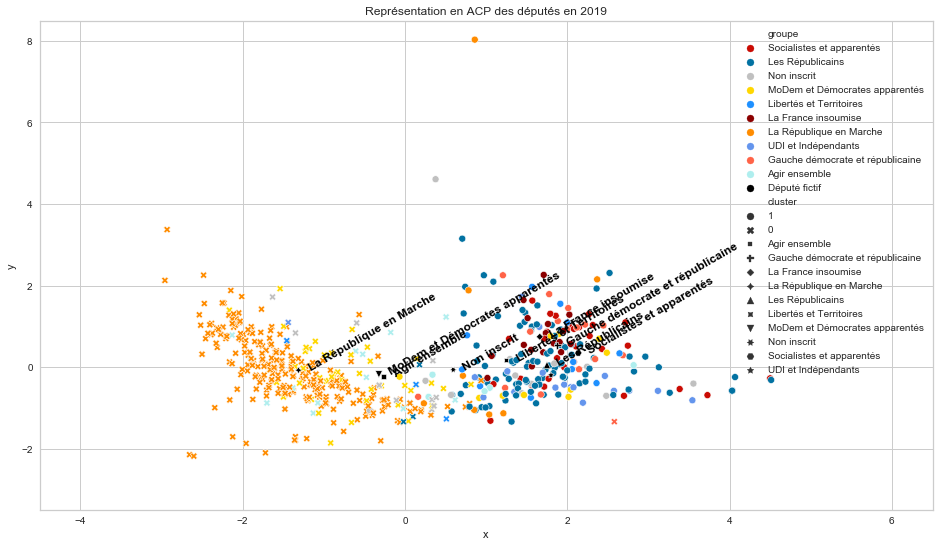

In [20]:
indices_cluster = df_indices[['cluster']]
cluster_fictif = pd.DataFrame(data=dep_fictif_2019.index, index=dep_fictif_2019.index, columns=indices_cluster.columns)
indices_cluster = indices_cluster.append(cluster_fictif)
indices_cluster.index.name = 'idVotant'

indices_2019 = indices_2019.merge(indices_cluster, on='idVotant', how='left')
groupe_fictif_2019 = pd.DataFrame(data=['Député fictif']*10, index=dep_fictif_2019.index, columns=groupe.columns)
groupe_etendu = groupe.append(groupe_fictif_2019)
groupe_etendu.index.name = 'idVotant'
indices_2019 = indices_2019.merge(groupe_etendu, on='idVotant', how='left')

groupe_to_labels = {groupe : idx for idx, groupe in enumerate(indices_2019.Groupe.unique())}
labels_to_groupe = {label : groupe for groupe, label in groupe_to_labels.items()}
labels = [groupe_to_labels[groupe] for groupe in indices_2019.Groupe]
indices_2019['labels'] = labels
indices_2019_acp = indices_2019.drop(['cluster','labels','Groupe'], axis=1)

indices_2019_transform = StandardScaler().fit_transform(indices_2019_acp)
pca = PCA(n_components=4).fit(indices_2019_transform)

print('Variance:',pca.explained_variance_ratio_)
print('Variance totale:',pca.explained_variance_ratio_.sum())

resultats_reduced = pca.transform(indices_2019_transform)
x_2019 = resultats_reduced[:, 0]
y_2019 = resultats_reduced[:, 1]

df_plot_2019 = pd.DataFrame(dict(x=x_2019, y=y_2019, label=labels))
df_plot_2019.index = indices_2019.index
df_plot_2019 = df_plot_2019.merge(indices_2019[['cluster']], on='idVotant', how='left')
df_plot_2019['groupe'] = df_plot_2019['label'].replace(labels_to_groupe)

plt.figure(figsize=(16,9))
plt.ylim([-3.5, 8.5])
plt.xlim([-4.5, 6.5])
plt.title('Représentation en ACP des députés en 2019')
g = sns.scatterplot(data=df_plot_2019, x='x', y='y', style='cluster', hue='groupe', palette=color_dict)

for line in range(574,583):
     plt.text(df_plot_2019.x[line]+0.1, df_plot_2019.y[line], df_plot_2019.cluster[line], 
              horizontalalignment='left', size='medium', color='black', weight='semibold', rotation=30.)

plt.legend(loc='upper right')
plt.savefig('indices_2019.png')
plt.savefig('2indices_2019.png')
plt.savefig('3indices_2019.png')
plt.savefig('4indices_2019.png')

### 2020

In [21]:
votes_2020 = df_votes[df_votes.date_scrutin >= "2020-01-01"].copy()

#taux de participation
nb_votes_2020 = votes_2020['idScrutin'].nunique()
participation_2020 = votes_2020.groupby('idVotant').count()
participation_2020['taux_participation'] = participation_2020['idScrutin']/(nb_votes_2020)*100
participation_2020 = participation_2020[['taux_participation']]
participation_2020 = participation_2020.merge(groupe, on='idVotant', how='left')
participation_groupe_2020 = participation_2020.groupby('Groupe').mean()
participation_2020 = participation_2020.drop('Groupe', axis=1)
participation_2020 = participation_2020.append(participation_groupe_2020)
participation_2020.index.name = 'idVotant'

#proportion vote
avis_votant_2020 = pd.DataFrame(votes_2020.groupby(['idVotant']).vote.value_counts())
avis_votant_2020 = avis_votant_2020.rename(columns={'vote':'nombre'})
total_votant_2020 = votes_2020.groupby(['idVotant']).vote.count()
proportion_2020 = pd.DataFrame({'Proportion' : np.round(avis_votant_2020['nombre'].div(total_votant_2020)*100, decimals=2)})
proportion_2020 = proportion_2020.unstack()
proportion_2020.columns = proportion_2020.columns.droplevel()
proportion_2020 = proportion_2020.drop('Nonvotant', axis=1)
proportion_2020 = proportion_2020.fillna(0)
proportion_2020 = proportion_2020.merge(groupe, on='idVotant', how='left')
proportion_groupe_2020 = proportion_2020.groupby('Groupe').mean()
proportion_2020 = proportion_2020.drop('Groupe', axis=1)
proportion_2020 = proportion_2020.append(proportion_groupe_2020)
proportion_2020.index.name = 'idVotant'


#indice accord
partis = pd.DataFrame(votes_2020.groupby('idVotant')['organeRefGroupe'].unique())
df_2020 = votes_2020[((votes_2020.vote == 'Pour') & (votes_2020.resultat == 'adopté')) | ((votes_2020.vote == 'Contre') & (votes_2020.resultat == 'rejeté'))]
accord_votant = df_2020.idVotant.value_counts() 
total_votant = votes_2020.idVotant.value_counts()
indice_accord_2020 = pd.DataFrame((np.round(accord_votant/total_votant*100, decimals=2))).rename(columns={'idVotant':'indice_accord'})
indice_accord_2020.index = indice_accord_2020.index.rename('idVotant')
indice_accord_2020 = indice_accord_2020.merge(groupe, on='idVotant', how='left')
indice_groupe_2020 = indice_accord_2020.groupby('Groupe').mean()
indice_accord_2020 = indice_accord_2020.drop('Groupe', axis=1)
indice_accord_2020 = indice_accord_2020.append(indice_groupe_2020)
indice_accord_2020.index.name = 'idVotant'


#df final
indices_2020 = proportion_2020.merge(indice_accord_2020, on='idVotant', how='left')
indices_2020 = indices_2020.merge(participation_2020, on='idVotant', how='left')
indices_2020 = indices_2020.fillna(0)

Variance: [0.74279242 0.20475868 0.04897688 0.00347202]
Variance totale: 0.9999999999999999


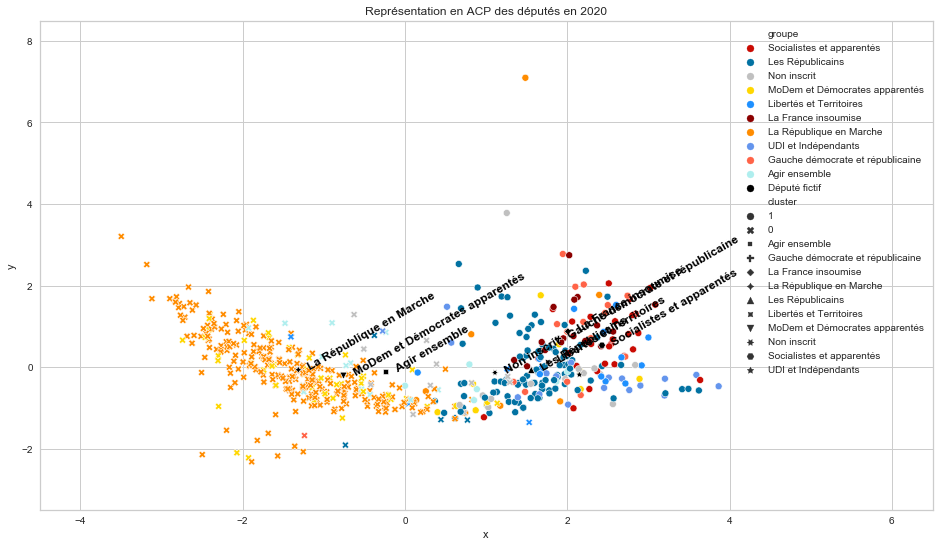

In [22]:
indices_cluster = df_indices[['cluster']]
cluster_fictif = pd.DataFrame(data=dep_fictif_2020.index, index=dep_fictif_2020.index, columns=indices_cluster.columns)
indices_cluster = indices_cluster.append(cluster_fictif)
indices_cluster.index.name = 'idVotant'

indices_2020 = indices_2020.merge(indices_cluster, on='idVotant', how='left')
groupe_fictif_2020 = pd.DataFrame(data=['Député fictif']*10, index=dep_fictif_2020.index, columns=groupe.columns)
groupe_etendu = groupe.append(groupe_fictif_2020)
groupe_etendu.index.name = 'idVotant'
indices_2020 = indices_2020.merge(groupe_etendu, on='idVotant', how='left')

groupe_to_labels = {groupe : idx for idx, groupe in enumerate(indices_2020.Groupe.unique())}
labels_to_groupe = {label : groupe for groupe, label in groupe_to_labels.items()}
labels = [groupe_to_labels[groupe] for groupe in indices_2020.Groupe]
indices_2020['labels'] = labels
indices_2020_acp = indices_2020.drop(['cluster','labels','Groupe'], axis=1)

indices_2020_transform = StandardScaler().fit_transform(indices_2020_acp)
pca = PCA(n_components=4).fit(indices_2020_transform)

print('Variance:',pca.explained_variance_ratio_)
print('Variance totale:',pca.explained_variance_ratio_.sum())

resultats_reduced = pca.transform(indices_2020_transform)
x_2020 = resultats_reduced[:, 0]
y_2020 = resultats_reduced[:, 1]

df_plot_2020 = pd.DataFrame(dict(x=x_2020, y=y_2020, label=labels))
df_plot_2020.index = indices_2020.index
df_plot_2020 = df_plot_2020.merge(indices_2020[['cluster']], on='idVotant', how='left')
df_plot_2020['groupe'] = df_plot_2020['label'].replace(labels_to_groupe)

plt.figure(figsize=(16,9))
plt.ylim([-3.5, 8.5])
plt.xlim([-4.5, 6.5])
plt.title('Représentation en ACP des députés en 2020')
g = sns.scatterplot(data=df_plot_2020, x='x', y='y', style='cluster', hue='groupe', palette=color_dict)

for line in range(575,584):
     plt.text(df_plot_2020.x[line]+0.1, df_plot_2020.y[line], df_plot_2020.cluster[line], 
              horizontalalignment='left', size='medium', color='black', weight='semibold', rotation=30.)

plt.legend(loc='upper right')
plt.savefig('indices_2020.png')
plt.savefig('2indices_2020.png')
plt.savefig('3indices_2020.png')
plt.savefig('4indices_2020.png')

In [23]:
image = [] 
filename = ['indices_2017.png', '2indices_2017.png', '3indices_2017.png', '4indices_2017.png',
            'indices_2018.png', '2indices_2018.png', '3indices_2018.png', '4indices_2018.png',
            'indices_2019.png', '2indices_2019.png', '3indices_2019.png', '4indices_2019.png',
            'indices_2020.png', '2indices_2020.png', '3indices_2020.png', '4indices_2020.png',] 
for file in filename: 
    image.append(imageio.imread(file)) 
    imageio.mimsave('indices.gif', image)
from IPython.display import Image
display(Image(url='indices.gif'))

# ACP député fictif par parti

In [24]:
dep_fictif_2017

,3,13,14,22,33,40,44,73,78,82,...,3075,3076,3081,3082,3088,3099,3102,3110,3112,3115
La République en Marche,Pour,Nonvotant,Nonvotant,Contre,Contre,Nonvotant,Nonvotant,Nonvotant,Contre,Pour,...,Contre,Nonvotant,Contre,Nonvotant,Nonvotant,Contre,Contre,Nonvotant,Nonvotant,Nonvotant
Les Républicains,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,...,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Pour,Nonvotant,Nonvotant,Nonvotant
MoDem et Démocrates apparentés,Nonvotant,Pour,Nonvotant,Nonvotant,Nonvotant,Contre,Nonvotant,Contre,Contre,Nonvotant,...,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Contre,Nonvotant,Nonvotant,Nonvotant
Socialistes et apparentés,Nonvotant,Pour,Nonvotant,Pour,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Pour,Nonvotant,...,Pour,Nonvotant,Nonvotant,Pour,Nonvotant,Nonvotant,Pour,Nonvotant,Pour,Nonvotant
Agir ensemble,Pour,Nonvotant,Nonvotant,Nonvotant,Pour,Contre,Contre,Nonvotant,Pour,Nonvotant,...,Nonvotant,Pour,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Contre,Nonvotant,Nonvotant,Nonvotant
UDI et Indépendants,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Pour,Contre,...,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant
Libertés et Territoires,Pour,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,...,Pour,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Pour,Nonvotant,Nonvotant,Nonvotant
Non inscrit,Pour,Nonvotant,Nonvotant,Pour,Pour,Contre,Contre,Contre,Pour,Contre,...,Nonvotant,Nonvotant,Pour,Nonvotant,Contre,Pour,Nonvotant,Nonvotant,Contre,Pour
La France insoumise,Nonvotant,Pour,Pour,Pour,Contre,Nonvotant,Nonvotant,Pour,Pour,Nonvotant,...,Nonvotant,Pour,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Pour,Nonvotant,Nonvotant
Gauche démocrate et républicaine,Pour,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Pour,Pour,Nonvotant,...,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant,Nonvotant


In [25]:
votes_2017

,idScrutin,idVotant,vote,organeRefGroupe,date_scrutin,code_type_vote,titre,demandeur,organe_ref,votants,...,Région,Département,Numéro de circonscription,Profession,Groupe politique (complet),Groupe politique (abrégé),date_naissance,type_mandat,type_organe,qualite_mandat
177,3,PA721824,Contre,PO730964,2017-10-19,SPO,l'amendement n° 400 de Mme Louwagie à l'articl...,"Président du groupe ""Les Républicains""",PO717460,107,...,Ile-de-France,Paris,13,Cadre supérieur (entreprises publiques),La République en Marche,LaREM,NaN,NaN,NaN,NaN
178,3,PA719108,Contre,PO730964,2017-10-19,SPO,l'amendement n° 400 de Mme Louwagie à l'articl...,"Président du groupe ""Les Républicains""",PO717460,107,...,Nouvelle-Aquitaine,Charente-Maritime,4,Cadre supérieur (secteur privé),La République en Marche,LaREM,NaN,NaN,NaN,NaN
179,3,PA719154,Contre,PO730964,2017-10-19,SPO,l'amendement n° 400 de Mme Louwagie à l'articl...,"Président du groupe ""Les Républicains""",PO717460,107,...,Bourgogne-Franche-Comté,Côte-d'Or,1,Neuroradiologue,La République en Marche,LaREM,NaN,NaN,NaN,NaN
180,3,PA720108,Contre,PO730964,2017-10-19,SPO,l'amendement n° 400 de Mme Louwagie à l'articl...,"Président du groupe ""Les Républicains""",PO717460,107,...,Pays de la Loire,Loire-Atlantique,2,Administrateur de sociétés,La République en Marche,LaREM,NaN,NaN,NaN,NaN
181,3,PA720154,Contre,PO730964,2017-10-19,SPO,l'amendement n° 400 de Mme Louwagie à l'articl...,"Président du groupe ""Les Républicains""",PO717460,107,...,Pays de la Loire,Maine-et-Loire,6,Retraitée de la fonction publique hospitalière...,La République en Marche,LaREM,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290341,3115,PA721624,Contre,PO730964,2017-12-18,SPO,l'article unique du projet de loi autorisant l...,"Président du groupe ""La France insoumise""",PO717460,37,...,Ile-de-France,Paris,8,Avocate,La République en Marche,LaREM,NaN,NaN,NaN,NaN
290342,3115,PA334768,Contre,PO730964,2017-12-18,SPO,l'article unique du projet de loi autorisant l...,"Président du groupe ""La France insoumise""",PO717460,37,...,Auvergne-Rhône-Alpes,Rhône,3,Professeur de médecine,La République en Marche,LaREM,1945-10-08,MandatParlementaire_type,ASSEMBLEE,membre
290343,3115,PA643134,Pour,PO730934,2017-12-18,SPO,l'article unique du projet de loi autorisant l...,"Président du groupe ""La France insoumise""",PO717460,37,...,Auvergne-Rhône-Alpes,Haute-Loire,1,Salariée agricole,Les Républicains,LR,NaN,NaN,NaN,NaN
290344,3115,PA721126,Pour,PO730934,2017-12-18,SPO,l'article unique du projet de loi autorisant l...,"Président du groupe ""La France insoumise""",PO717460,37,...,Saint-Barthélemy et Saint-Martin,Saint-Barthélemy et Saint-Martin,1,Directrice générale adjointe d'hôtel,Les Républicains,LR,NaN,NaN,NaN,NaN
